# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'
apply_kernels = True

# Define search period
start_date = '2021-11-04'
end_date = '2021-11-04'

# Define extent
lon_min = 6
lon_max = 10
lat_min = 44
lat_max = 46

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

In [5]:
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

# Generate array with search dates
dates = search_period(start_date, end_date, sensor, sensor_type)

The comparison is possible and will start now.
SEARCH PERIOD
- In days: [('2021-11-04T00:00:00Z', '2021-11-04T23:00:00Z')]


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

2021-11-14 13:12:01,876 INFO Welcome to the CDS
2021-11-14 13:12:01,877 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts


The file does not exist, it will be downloaded.


2021-11-14 13:12:01,950 INFO Request is completed
2021-11-14 13:12:01,951 INFO Downloading https://download-0003.copernicus-atmosphere.eu/cache-compute-0003/cache/data9/adaptor.mars_constrained.internal-1636560466.199042-10919-7-bd6e0517-479e-45c8-b011-d7891d062caf.grib to data/cams/NO2/NO2-hourly-levels-2021-11-04-2021-11-04.grib (1.2G)
2021-11-14 13:12:21,390 INFO Download rate 65.5M/s


In [7]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 8, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 2021-11-04
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 3.228e-09 ....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-14T13:12 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model, model_ds, sensor, 
                                      component_mol_weight, component, model_levels_df,
                                      start_date, end_date, component_nom, apply_kernels)

2021-11-14 13:12:33,499 INFO Welcome to the CDS
2021-11-14 13:12:33,499 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-11-14 13:12:33,517 INFO Request is queued
2021-11-14 13:12:34,525 INFO Request is running
2021-11-14 13:12:38,293 INFO Request is completed
2021-11-14 13:12:38,294 INFO Downloading https://download-0002.copernicus-atmosphere.eu/cache-compute-0002/cache/data0/adaptor.mars_constrained.internal-1636895556.6391811-5261-12-0828d50b-1cd8-4085-984d-2819cc38eebc.grib to data/cams/NO2/surface-pressure-2021-11-04-2021-11-04.grib (6.2M)
2021-11-14 13:12:38,478 INFO Download rate 34.1M/s


The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [10]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

2021-11-14 13:13:16,416 INFO Welcome to the CDS
2021-11-14 13:13:16,416 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2021-11-14 13:13:16,430 INFO Request is queued


The file does not exist, it will be downloaded.


2021-11-14 13:13:17,439 INFO Request is running
2021-11-14 13:13:21,208 INFO Request is completed
2021-11-14 13:13:21,209 INFO Downloading https://download-0000.copernicus-atmosphere.eu/cache-compute-0000/cache/data5/adaptor.mars_constrained.internal-1636895599.1845615-25588-2-1c4c7db8-ed4a-4aad-9a6e-3b1f19539a27.grib to data/cams/NO2/NO2-hourly-tc-2021-11-04-2021-11-04.grib (9.3M)
2021-11-14 13:13:21,398 INFO Download rate 49.3M/s


<xarray.Dataset>
Dimensions:     (latitude: 6, longitude: 11, step: 8, time: 1)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-11-04
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 44.0 44.4 44.8 45.2 45.6 46.0
  * longitude   (longitude) float64 6.0 6.4 6.8 7.2 7.6 8.0 8.4 8.8 9.2 9.6 10.0
    valid_time  (step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 5.27e-06 ... 4.777e-06
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-11-14T13:13 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_total_ds, _ = model_convert_units(model, model_total_ds, sensor,
                                        component_mol_weight, component, model_levels_df,
                                        start_date, end_date, component_nom, apply_kernels)

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [12]:
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-11-04T00:00:00Z', '2021-11-04T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-11-14 13:13:22,569 INFO Found 1 products
2021-11-14 13:13:23,993 INFO Downloading efad3ab6-f0a7-4635-afa6-7f2fa282ce65 to data/tropomi/NO2/2021-11-04/S5P_NRTI_L2__NO2____20211104T115216_20211104T115716_21041_02_020200_20211104T123747.nc


SELECTED
File name: efad3ab6-f0a7-4635-afa6-7f2fa282ce65
Product name: S5P_NRTI_L2__NO2____20211104T115216_20211104T115716_21041_02_020200_20211104T123747.nc
The file does not exist, it will be downloaded.


Downloading:   0%|          | 0.00/63.6M [00:00<?, ?B/s]

MD5 checksumming:   0%|          | 0.00/63.6M [00:00<?, ?B/s]

In [13]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 1, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [15]:
match_table = generate_match_table(sensor_ds, model_ds, bbox,  
                                   sensor, component_nom, apply_kernels)
match_table

The layers pressures will be calculated (lower and upper bounds).
The dataset does not contain any apriori profile.
FOR EST. TIME: 2021-11-04T00:00:00.000000000
This dataset contains data to apply the averaging kernels.


pressure   index  \
time       ground_pixel scanline layer                          
2021-11-04 62.0         9.0      0.0    100607.875000       0   
                                 1.0     99280.468750       2   
                                 2.0     96927.593750       4   
                                 3.0     93416.968750       6   
                                 4.0     88376.507812       8   
...                                               ...     ...   
           124.0        69.0     29.0      625.780151  783826   
                                 30.0      309.465515  783828   
                                 31.0      130.429565  783830   
                                 32.0       44.064754  783832   
                                 33.0        9.304465  783834   

                                                    delta_time   latitude  \
time       ground_pixel scanline layer                                      
2021-11-04 62.0         9.0      0.0   2021-11-04 11:52:18.578  42.830585   
                                 1.0   2021-11-04 11:52:18.578  42.830585   
                                 2.0   2021-11-04 11:52:18.578  42.830585   
                                 3.0   2021-11-04 11:52:18.578  42.830585   
                                 4.0   2021-11-04 11:52:18.578  42.830585   
...                                                        ...        ...   
           124.0        69.0     29.0  2021-11-04 11:53:08.977  47.138039   
                                 30.0  2021-11-04 11:53:08.977  47.138039   
                                 31.0  2021-11-04 11:53:08.977  47.138039   
                                 32.0  2021-11-04 11:53:08.977  47.138039   
                                 33.0  2021-11-04 11:53:08.977  47.138039   

                                        longitude  qa_value  sensor_column  \
time       ground_pixel scanline layer                                       
2021-11-04 62.0         9.0      0.0     6.744758      1.00   3.048095e+15   
                                 1.0     6.744758      1.00   3.048095e+15   
                                 2.0     6.744758      1.00   3.048095e+15   
                                 3.0     6.744758      1.00   3.048095e+15   
                                 4.0     6.744758      1.00   3.048095e+15   
...                                           ...       ...            ...   
           124.0        69.0     29.0    9.408672      0.73   2.422727e+15   
                                 30.0    9.408672      0.73   2.422727e+15   
                                 31.0    9.408672      0.73   2.422727e+15   
                                 32.0    9.408672      0.73   2.422727e+15   
                                 33.0    9.408672      0.73   2.422727e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
time       ground_pixel scanline layer                                                  
2021-11-04 62.0         9.0      0.0                                         0.000022   
                                 1.0                                         0.000022   
                                 2.0                                         0.000022   
                                 3.0                                         0.000022   
                                 4.0                                         0.000022   
...                                                                               ...   
           124.0        69.0     29.0                                        0.000025   
                                 30.0                                        0.000025   
                                 31.0                                        0.000025   
                                 32.0                                        0.000025   
                                 33.0                                        0.000025   

                        

## 5. Merge data and calculate difference

In [16]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, sensor, apply_kernels)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
9.0      62.0         2021-11-04  42.830585   6.744758  1.426929e+15   
         63.0         2021-11-04  42.863625   6.827712  1.429632e+15   
         64.0         2021-11-04  42.896194   6.909844  1.428048e+15   
         65.0         2021-11-04  42.928307   6.991175  1.425844e+15   
         66.0         2021-11-04  42.959957   7.071721  1.636400e+15   
...                                     ...        ...           ...   
69.0     120.0        2021-11-04  47.068211   9.180054  1.076596e+15   
         121.0        2021-11-04  47.085903   9.237603  1.196164e+15   
         122.0        2021-11-04  47.103439   9.294887  1.291141e+15   
         123.0        2021-11-04  47.120819   9.351909  1.239026e+15   
         124.0        2021-11-04  47.138039   9.408672  1.138169e+15   

                                  sensor_column    difference  
scanline ground_pixel time                                     
9.0      62.0         2021-11-04   3.048095e+15  1.621165e+15  
         63.0         2021-11-04   3.117365e+15  1.687733e+15  
         64.0         2021-11-04   3.668372e+15  2.240323e+15  
         65.0         2021-11-04   2.971671e+15  1.545827e+15  
         66.0         2021-11-04   3.741950e+15  2.105550e+15  
...                                         ...           ...  
69.0     120.0        2021-11-04   1.895028e+15  8.184321e+14  
         121.0        2021-11-04   2.738141e+15  1.541977e+15  
         122.0        2021-11-04   3.002374e+15  1.711233e+15  
         123.0        2021-11-04   2.304393e+15  1.065367e+15  
         124.0        2021-11-04   2.422727e+15  1.284558e+15  

[3843 rows x 5 columns]

In [17]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,3843.000000,3843.000000,3.801000e+03,3.801000e+03,3.801000e+03
mean,45.056488,8.191612,1.700726e+15,2.856614e+15,1.155888e+15
std,0.936838,1.291597,1.139256e+15,1.949843e+15,1.271869e+15
min,42.830585,5.154696,2.832558e+14,-2.195396e+14,-2.254919e+15
25%,44.332384,7.163081,8.188432e+14,1.523251e+15,4.035840e+14
50%,45.054111,8.262411,1.384568e+15,2.394742e+15,9.026265e+14
75%,45.780304,9.249781,2.290515e+15,3.646675e+15,1.679693e+15
max,47.138039,10.826918,6.304778e+15,1.624738e+16,1.080661e+16


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-11-04T00:00:00.000000000']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((6, 44), (10, 46))


### Compare CAMS and TROPOMI total columns

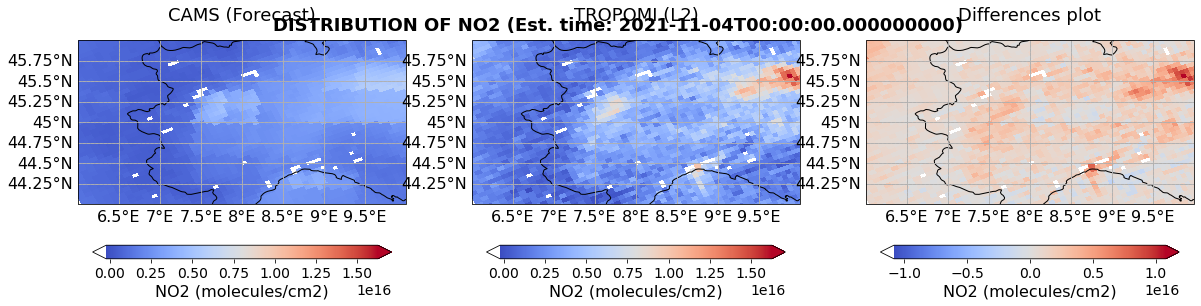

In [20]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 
units = 'molecules/cm2'
visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

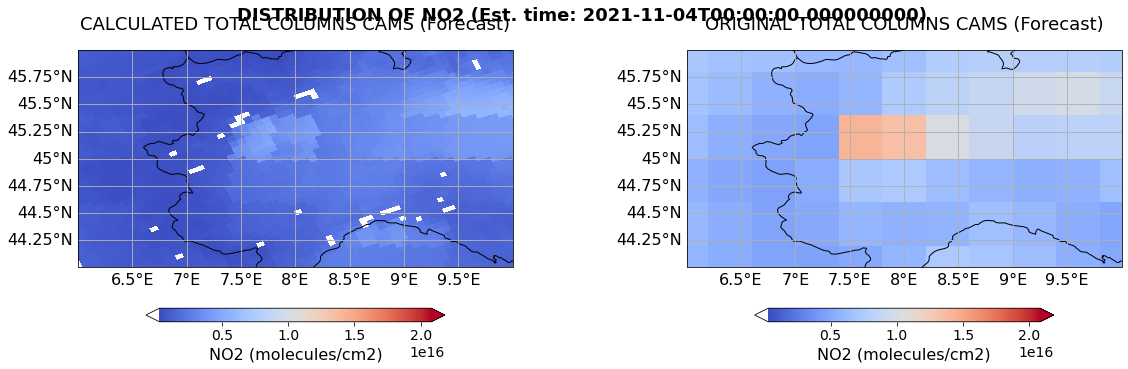

In [21]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [22]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

,,,,,scanline,ground_pixel,model_column,sensor_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,44.273174,10.826918,2021-11-04,9.0,124.0,1.078711e+15,2.828364e+15,1.749653e+15
4,10,42.830585,6.744758,2021-11-04,9.0,62.0,1.426929e+15,3.048095e+15,1.621165e+15
20,30,44.273174,10.826918,2021-11-04,9.0,124.0,1.078711e+15,2.828364e+15,1.749653e+15


## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.48 + (3.89E+14)
Coefficient of determination (R2): 0.68


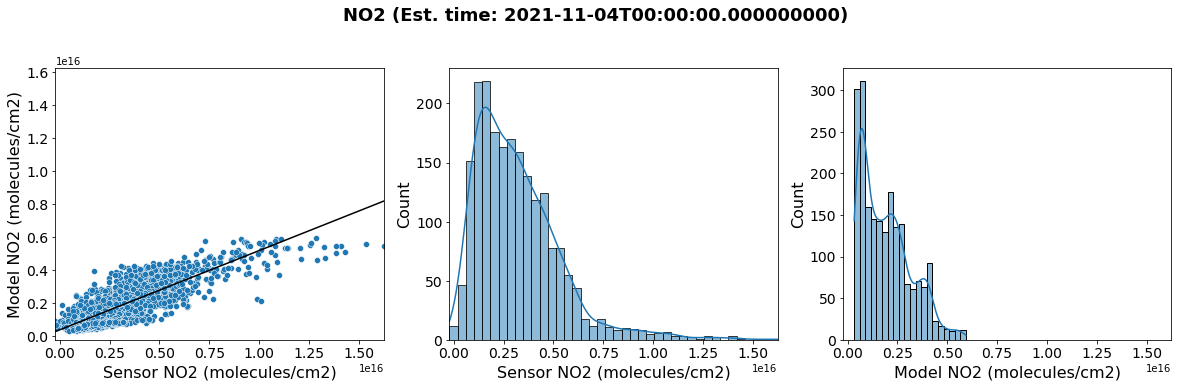

In [23]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,2021-11-04,"((6, 44), (10, 46))",0.684842,0.479684,3.887687e+14


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.46 + (3.93E+14)
Coefficient of determination (R2): 0.61


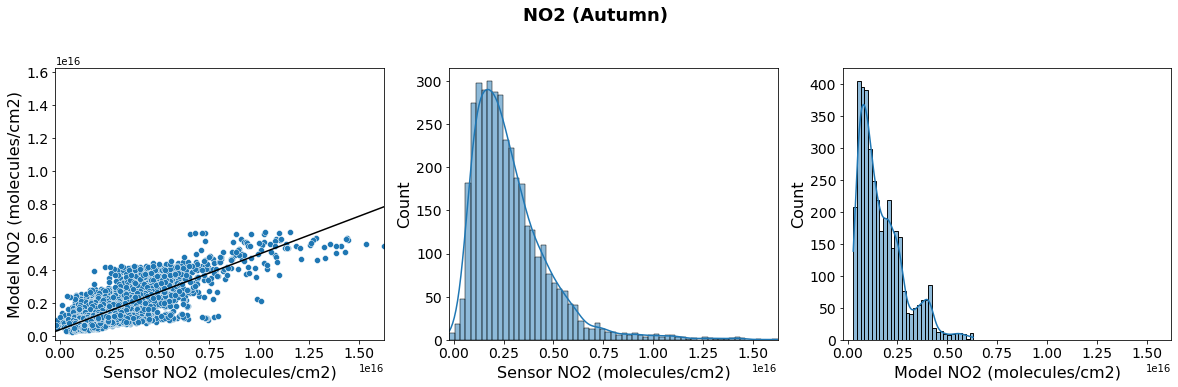

In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [26]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((6, 44), (10, 46))",0.614315,0.457949,3.925425e+14


## 10. Scatter plots by country (Google API required!)

In [27]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [28]:
#summary